In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv

In [7]:
for file_name in os.listdir('Data/'):
    if fnmatch.fnmatch(file_name, '*.dat'):
        print(file_name)

ZLP_200 keV_2ms_008.dat
ZLP_200 keV_2ms_009.dat
01.dat
ZLP_200 keV_2ms_007.dat
ZLP_200 keV_2ms_006.dat
ZLP_200 keV_2ms_010.dat
ZLP_200 keV_2ms_004.dat
ZLP_200 keV_2ms_005.dat
ZLP_200 keV_2ms_002.dat
ZLP_200 keV_2ms_003.dat



 ***************************************************** 



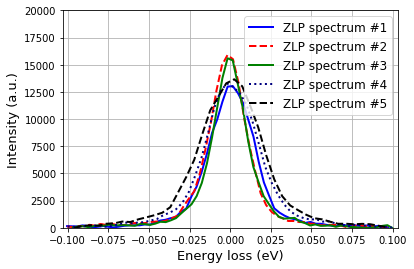

In [8]:
%run EELS-ZLP.py